# Advanced Lane Lines - Sliding window

In this notebook the following points from the Project 5 Vehicle Detection are implemented:
*  Implement a sliding-window technique and use your trained classifier to search for vehicles in images. 


---
## Step 0: Import required libraries

In [1]:
from IPython.core.display import display, HTML

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import pickle
import cv2
import glob
import time
import os

from feature_extraction import extractFeatures, configParams, extract_hog_features, extract_color_features


## Step 1:  Udacity helper functions to detect cars in an image by sliding and searching window

In [2]:
def search_windows(img, windows, classifier, X_scaler):

    hog_feat = configParams['use_hog_feat']
    spatial_feat = configParams['use_spatial_feat']
    hist_feat = configParams['use_hist_feat']
    
    # Create an empty list to receive positive detection windows
    on_windows = []
    
    count_window = 0
    count_car_window = 0
    # Iterate over all windows in the list
    for window in windows:
        
        # Extract the test window from original image
        window_img = cv2.resize(img[window[0][1]:window[1][1], 
                                  window[0][0]:window[1][0]], 
                              (64, 64))      
        
        # Extract features for that window
        img_features = extractFeatures(window_img, verbose=False, 
                                hog_feat=hog_feat, spatial_feat=spatial_feat, hist_feat=hist_feat)                
        
        # Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(img_features).reshape(1, -1))
        
        # Predict using your classifier
        prediction = classifier.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        count_window += 1
        if prediction == 1:
            count_car_window += 1
            on_windows.append(window)
            
    
    # Return windows for positive detections
    return on_windows

In [3]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [4]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):

    imcopy = np.copy(img)
    
    for bbox in bboxes:
        # Draw a rectangle
        cv2.rectangle(imcopy, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), 
                      color, thick)

    return imcopy

## Step 2: Test sliding and searching window approach on test images

In [5]:
def testSlidingSearchWindowOnImages():    
    
    # Test images    
    count_fig = 1
    filenames_img = glob.glob('./test_images/test*.jpg')
    
    svc, X_scaler = pickle.load( open("./classifier_pickle.p", "rb" ) )
    
    for filename_img in filenames_img:
        
        # Read image
        image = mpimg.imread(filename_img)
        draw_image = np.copy(image)
        
        # Normalize image intensity, since we read in a jpg
        image = image.astype(np.float32)/255
        
        y_start_stop = [np.int(image.shape[0]/2), image.shape[0] - 60]        
        hot_windows = []
        all_windows = []
        # HOG features extracted on every search window separately
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(96, 96), xy_overlap=(0.5, 0.5))

        hot_windows = search_windows(image, windows, svc, X_scaler)                                   

        print("\n# hot-windows: {}".format(len(hot_windows)))
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        
        fig = plt.figure(count_fig, figsize=(15, 15), dpi=100)
        plt.subplot(131)
        plt.imshow(window_img)
        plt.title('Hot windows in test image') 
        fig.tight_layout()
        count_fig += 1
    
    plt.show() 

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



# hot-windows: 5

# hot-windows: 5

# hot-windows: 5

# hot-windows: 0

# hot-windows: 2

# hot-windows: 0


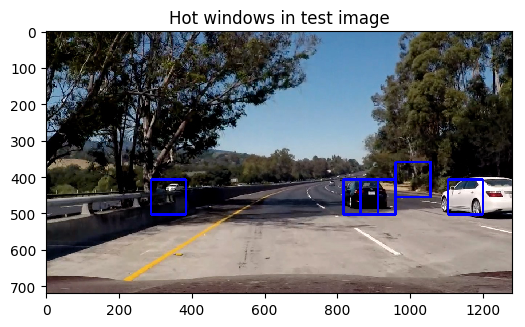

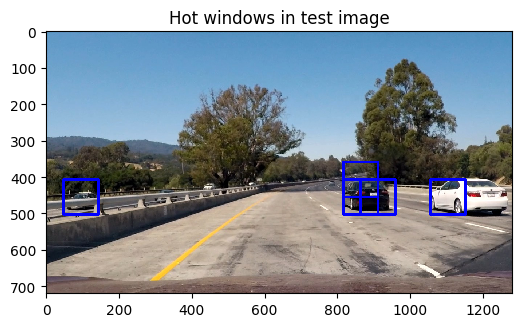

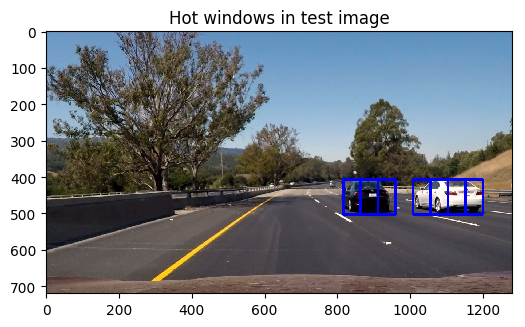

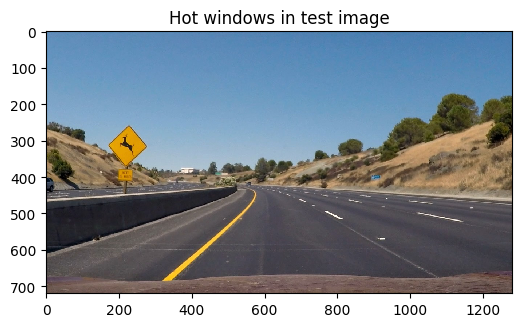

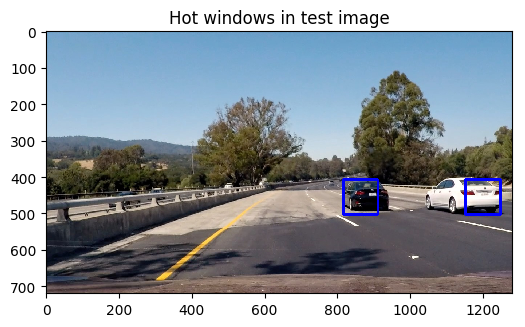

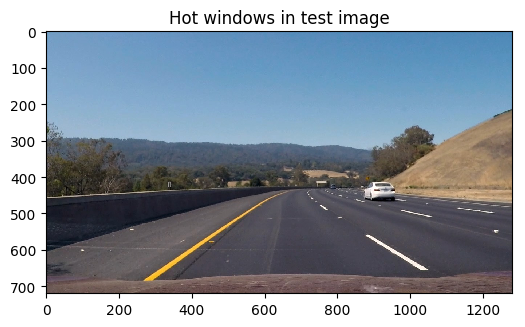

In [6]:
testSlidingSearchWindowOnImages()

## Step 3: Helper function to detect cars in an image by using HOG sub-sampling in sliding window

In [7]:
def findCars(img, y_start_stop, svc, X_scaler, scale=1):
    
    hog_feat = configParams['use_hog_feat']
    spatial_feat = configParams['use_spatial_feat']
    hist_feat = configParams['use_hist_feat']
    
    car_windows = []
    all_windows = []
    
    draw_img = np.copy(img)
    
    img_cropped = img[y_start_stop[0]:y_start_stop[1], :, :]
    
    if scale != 1:
        imshape = img_cropped.shape
        img_cropped = cv2.resize(img_cropped, 
                                 (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_cropped[:,:,0]
    ch2 = img_cropped[:,:,1]
    ch3 = img_cropped[:,:,2]

    orient = configParams['hog_n_orientations']
    pix_per_cell = configParams['hog_pixels_per_cell']
    cells_per_block = configParams['hog_cells_per_block']
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cells_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cells_per_block + 1 
    nfeat_per_block = orient * cells_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cells_per_block + 1
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute HOG features for the entire image
    hogg, _ = extract_hog_features(img_cropped, hog_feat=hog_feat, visualize=False)    
    
    # sprint ("hogg.shape = {}".format(hogg.shape))
    hog1 = hogg[0]
    hog2 = hogg[1]
    hog3 = hogg[2]
    
    count_window = 0
    count_car_window = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))            
            
            if configParams['use_gray_img'] is True:
                hog_features = hogg[ypos:ypos+nblocks_per_window, 
                                            xpos:xpos+nblocks_per_window].ravel()                         

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_cropped[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            color_features = extract_color_features(subimg, spatial_feat=spatial_feat, hist_feat=hist_feat)
            
            # Combine HOG and color features
            img_features = np.hstack((hog_features, color_features))

            # Scale features and make a prediction            
            test_features = X_scaler.transform(img_features.reshape(1, -1))
               
            test_prediction = svc.predict(test_features)
                        
            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            
            count_window += 1
            all_windows.append(((xbox_left, ytop_draw + y_start_stop[0]),
                              (xbox_left + win_draw, ytop_draw + win_draw + y_start_stop[0])))
            if test_prediction == 1:
                count_car_window += 1
                
                car_windows.append(((xbox_left, ytop_draw + y_start_stop[0]),
                              (xbox_left + win_draw, ytop_draw + win_draw + y_start_stop[0])))
                cv2.rectangle(draw_img,
                              car_windows[-1][0], car_windows[-1][1],
                              (0, 255, 0), 6) 
    
    
    return all_windows, car_windows 

## Step 4: Test HOG subsampling an all test images

In [8]:
def testHOGSubsamplingSilidingOnImages():    
    
    # Test images    
    count_fig = 1
    filenames_img = glob.glob('./test_images/test*.jpg')
    svc, X_scaler = pickle.load( open("./classifier_pickle.p", "rb" ) )
    
    for filename_img in filenames_img:
        
        # Read image
        image = mpimg.imread(filename_img)
        draw_image = np.copy(image)
        
        # Normalize image intensity, since we read in a jpg
        image = image.astype(np.float32)/255
        
        y_start_stop=[350, 656]
        hot_windows = []
        all_windows = []
        windows, car_windows = findCars(image, y_start_stop, svc, X_scaler, scale=1.5)
        hot_windows += car_windows
        all_windows += windows
                                  

        print("\n# hot-windows: {}".format(len(hot_windows)))
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        
        fig = plt.figure(count_fig, figsize=(15, 15), dpi=100)
        plt.subplot(131)
        plt.imshow(window_img)
        plt.title('Hot windows in test image')    
        fig.tight_layout()
        count_fig += 1
    
    plt.show() 

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



# hot-windows: 14

# hot-windows: 12

# hot-windows: 14

# hot-windows: 0

# hot-windows: 12

# hot-windows: 2


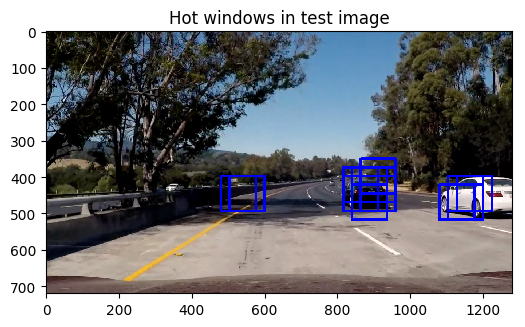

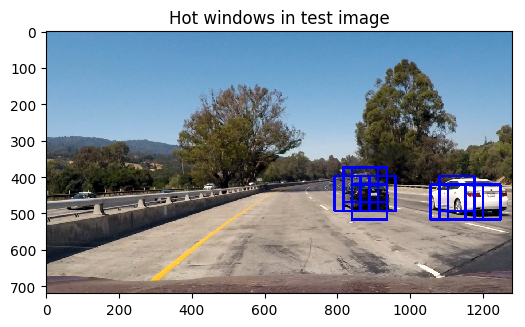

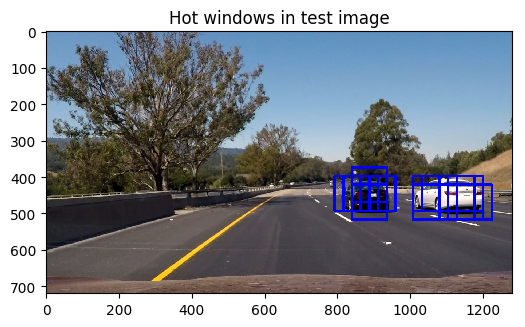

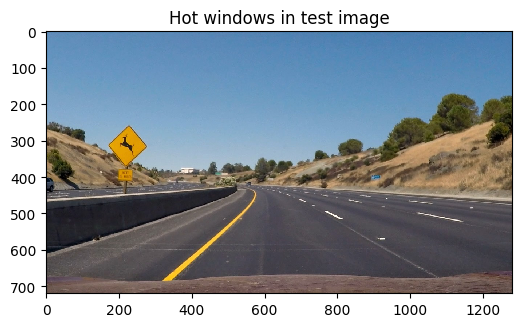

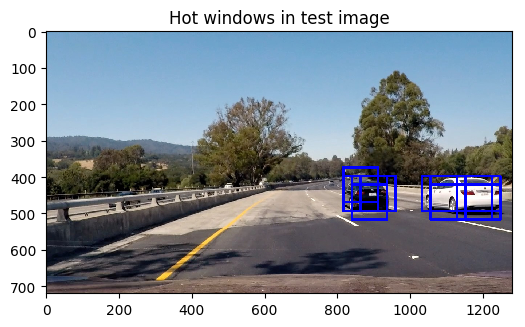

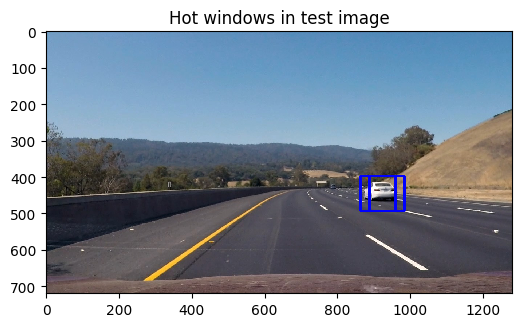

In [9]:
testHOGSubsamplingSilidingOnImages() 